In [10]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras import backend as K


def focal_loss(gamma=2., alpha=0.25):
    def focal_loss_fixed(y_true, y_pred):
        y_true = tf.cast(y_true, tf.int32)
        y_true = tf.one_hot(y_true, depth=3)  # 3 classes (0, 1, 2)
        
        y_pred = tf.clip_by_value(y_pred, K.epsilon(), 1. - K.epsilon())
        cross_entropy = -y_true * tf.math.log(y_pred)
        loss = alpha * tf.math.pow(1 - y_pred, gamma) * cross_entropy
        return tf.reduce_mean(tf.reduce_sum(loss, axis=1))
    return focal_loss_fixed


# Paths
TRAIN_DIR = './Train'
TEST_DIR = './Test'
LABELS_FILE = './label_train.csv'

In [11]:
# Load labels
labels_df = pd.read_csv(LABELS_FILE)

# Load training data
def load_data(directory, labels_df):
    X = []
    y = []
    for idx, row in labels_df.iterrows():
        file_name = f"{row['ID']}.npy"
        file_path = os.path.join(directory, file_name)
        sample = np.load(file_path)
        X.append(sample)
        y.append(row['target'])
    return np.array(X), np.array(y)

X, y = load_data(TRAIN_DIR, labels_df)

print(f"Training data shape: {X.shape}")

Training data shape: (1491, 72, 48)


In [12]:
# Normalize data
X = (X - np.mean(X)) / np.std(X)

# Split into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Expand dimensions if needed (add channel dimension)
X_train = np.expand_dims(X_train, axis=-1)
X_val = np.expand_dims(X_val, axis=-1)

# Automatically calculate class weights
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
class_weights_dict = dict(enumerate(class_weights))

In [13]:
# Build the CNN model
def build_model():
    model = keras.Sequential([
        layers.Input(shape=(72, 48, 1)),
        
        layers.Rescaling(1./255),  # Normalize input to [0, 1]

        layers.Conv2D(32, (3, 3), padding='same'),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.MaxPooling2D((2, 2)),

        layers.Conv2D(64, (3, 3), padding='same'),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.MaxPooling2D((2, 2)),

        layers.Conv2D(128, (3, 3), padding='same'),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.MaxPooling2D((2, 2)),

        layers.Conv2D(256, (3, 3), padding='same'),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.GlobalAveragePooling2D(),  # replaces flatten

        layers.Dense(64, activation='relu'),
        layers.Dropout(0.4),

        layers.Dense(3, activation='softmax')
    ])
    
    model.compile(optimizer=Adam(0.001),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

model = build_model()
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_1 (Rescaling)         │ (None, 72, 48, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 72, 48, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 72, 48, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_4 (Activation)       │ (None, 72, 48, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 36, 24, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 36, 24, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 36, 24, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_5 (Activation)       │ (None, 36, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 18, 12, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 18, 12, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 18, 12, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_6 (Activation)       │ (None, 18, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 9, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 9, 6, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 9, 6, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_7 (Activation)       │ (None, 9, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 256)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 406,403 (1.55 MB)

 Trainable params: 405,443 (1.55 MB)

 Non-trainable params: 960 (3.75 KB)

In [ ]:
# Train the model without data augmentation
history = model.fit(
    X_train, y_train,
    batch_size=20,
    validation_data=(X_val, y_val),
    epochs=30,
    class_weight=class_weights_dict,
    callbacks=[
        keras.callbacks.EarlyStopping(patience=90, monitor='val_loss', verbose=1, restore_best_weights=True),
        keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.000001)
    ]
)

Epoch 1/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - accuracy: 0.8146 - loss: 0.5577 - val_accuracy: 0.0936 - val_loss: 2.5456 - learning_rate: 0.0010
Epoch 2/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - accuracy: 0.9674 - loss: 0.1738 - val_accuracy: 0.0936 - val_loss: 1.6798 - learning_rate: 0.0010
Epoch 3/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - accuracy: 0.9766 - loss: 0.1612 - val_accuracy: 0.0936 - val_loss: 1.2893 - learning_rate: 0.0010
Epoch 4/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - accuracy: 0.9805 - loss: 0.1681 - val_accuracy: 0.0936 - val_loss: 2.5469 - learning_rate: 0.0010
Epoch 5/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - accuracy: 0.9801 - loss: 0.1559 - val_accuracy: 0.0936 - val_loss: 1.4876 - learning_rate: 0.0010
Epoch 6/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - accuracy: 0.9755 - loss: 0.1654 - val_accuracy: 0.8127 - val_loss: 1.4650 - learning_rate: 0.0010
Epoch 7/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - accuracy: 0.9814 - loss: 0.1293 - val_acc

In [16]:
# Load test data
def load_test_data(directory):
    files = sorted(os.listdir(directory), key=lambda x: int(x.split('.')[0]))
    X_test = []
    file_names = []
    for file in files:
        file_path = os.path.join(directory, file)
        sample = np.load(file_path)
        X_test.append(sample)
        file_names.append(file.split('.')[0])
    return np.array(X_test), file_names

X_test, test_file_names = load_test_data(TEST_DIR)
X_test = (X_test - np.mean(X_test)) / np.std(X_test)
X_test = np.expand_dims(X_test, axis=-1)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
10/10 - 0s - 11ms/step - accuracy: 1.0000 - loss: 0.0060
Validation Accuracy: 1.0000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


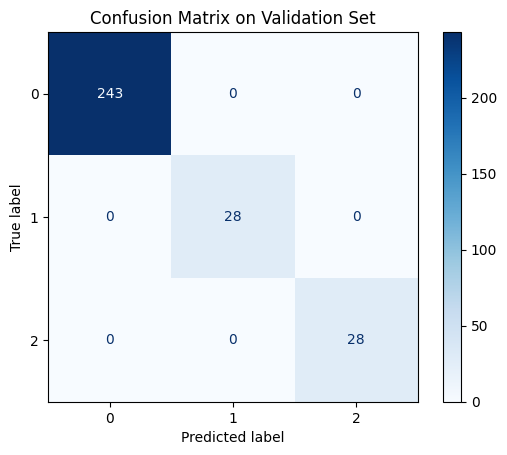

In [17]:
# Predict
predictions = model.predict(X_test)
predicted_labels = np.argmax(predictions, axis=1)

# Evaluate model on validation set
val_loss, val_accuracy = model.evaluate(X_val, y_val, verbose=2)
print(f"Validation Accuracy: {val_accuracy:.4f}")

# Predict on validation set
y_val_pred = model.predict(X_val)
y_val_pred_classes = np.argmax(y_val_pred, axis=1)

# Compute confusion matrix
cm = confusion_matrix(y_val, y_val_pred_classes)

# Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1, 2])
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix on Validation Set')
plt.show()

In [18]:
# Save for Kaggle
submission = pd.DataFrame({
    'ID': test_file_names,
    'target': predicted_labels
})
submission.to_csv('submission.csv', index=False)

print("Submission file saved as submission.csv")

Submission file saved as submission.csv
